# 1: Linear Units in Keras

With the first argument, units, we define how many outputs we want. In this case we are just predicting 'calories', so we'll use units=1.

With the second argument, input_shape, we tell Keras the dimensions of the inputs. Setting input_shape=[3] ensures the model will accept three features as input ('sugars', 'fiber', and 'protein').

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

# Create a network with 1 linear unit
model = keras.Sequential([
    layers.Dense(units=1, input_shape=[3])
])

# 2: Deep neural networks

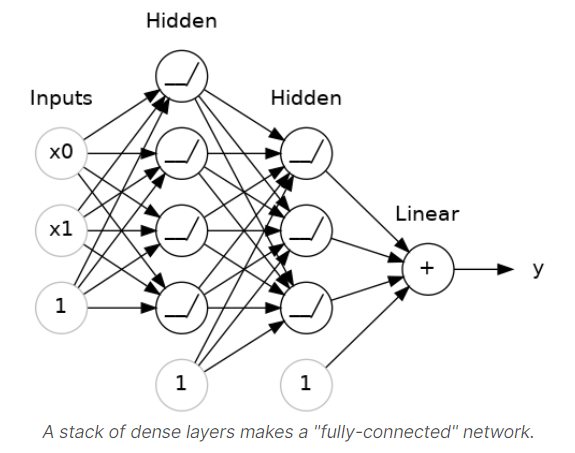

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=4, activation='relu', input_shape=[2]),
    layers.Dense(units=3, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1),
])

Be sure to pass all the layers together in a list, like [layer, layer, layer, ...], instead of as separate arguments. To add an activation function to a layer, just give its name in the activation argument.

The usual way of attaching an activation function to a Dense layer is to include it as part of the definition with the activation argument. Sometimes though you'll want to put some other layer between the Dense layer and its activation function. (We'll see an example of this in Lesson 5 with batch normalization.) In this case, we can define the activation in its own Activation layer, like so:

In [ ]:
layers.Dense(units=8),
layers.Activation('relu')

There is a whole family of variants of the 'relu' activation -- 'elu', 'selu', and 'swish', among others -- all of which you can use in Keras. Sometimes one activation will perform better than another on a given task, so you could consider experimenting with activations as you develop a model. The ReLU activation tends to do well on most problems, so it's a good one to start with.

To see the graph:

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

from tensorflow import keras
from tensorflow.keras import layers

# Change 'relu' to 'elu', 'selu', 'swish'... or something else
activation_layer = layers.Activation('selu')

x = tf.linspace(-3.0, 3.0, 100)
y = activation_layer(x) # once created, a layer is callable just like a function

plt.figure(dpi=100)
plt.plot(x, y)
plt.xlim(-3, 3)
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

# 3: Stochastic gradient descent

In addition to the training data, we need two more things:

A "loss function" that measures how good the network's predictions are.
An "optimizer" that can tell the network how to change its weights.

- The **loss function** measures the disparity between the the target's true value and the value the model predicts. A common loss function for regression problems is the mean absolute error or MAE. For each prediction y_pred, MAE measures the disparity from the true target y_true by an absolute difference abs(y_true - y_pred).

- The **optimizer** is an algorithm that adjusts the weights to minimize the loss. Virtually all of the optimization algorithms used in deep learning belong to a family called stochastic gradient descent. Each iteration's sample of training data is called a minibatch (or often just "batch"), while a complete round of the training data is called an epoch. 

- The **learning rate** and the size of the minibatches are the two parameters that have the largest effect on how the SGD training proceeds.

After defining a model, you can add a loss function and optimizer with the model's compile method:

In [ ]:
model.compile(
    optimizer="adam",
    loss="mae",
)

Example for a dataset with 11 features, model with 3 layers:

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mae',
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=10,
)

In [ ]:
# Plot the loss
import pandas as pd

# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

With the learning rate and the batch size, you have some control over:
- How long it takes to train a model
- How noisy the learning curves are
- How small the loss becomes

# 4: Overfitting and Underfitting

The **training loss** will go down either when the model learns signal or when it learns noise. But the **validation loss** will go down only when the model learns signal. (Whatever noise the model learned from the training set won't generalize to new data.) So, when a model learns signal both curves go down, but when it learns noise a gap is created in the curves. The size of the gap tells you how much noise the model has learned.  
⇒ Trade-off : We can get the model to learn more signal at the cost of learning more noise.

A model's **capacity** refers to the size and complexity of the patterns it is able to learn. For neural networks, this will largely be determined by how many neurons it has and how they are connected together. If it appears that your network is underfitting the data, you should try increasing its capacity.  
You can increase the capacity of a network either by making it wider (more units to existing layers) or by making it deeper (adding more layers). Wider networks have an easier time learning more linear relationships, while deeper networks prefer more nonlinear ones.

In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

wider = keras.Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])

deeper = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

When a model is too eagerly learning noise, the validation loss may start to increase during training. To prevent this, we can simply stop the training whenever it seems the validation loss isn't decreasing anymore. Interrupting the training this way is called **early stopping**.  
In Keras, we include early stopping in our training through a callback. A callback is just a function you want run every so often while the network trains. The early stopping callback will run after every epoch. 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# After defining the callback, add it as an argument in fit.
# Choose a large number of epochs when using early stopping, more than you'll need.
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# 5: Dropout and batch normalization

The **dropout layer** can help correct overfitting.  
In Keras, the dropout rate argument rate defines what percentage of the input units to shut off. Put the Dropout layer just before the layer you want the dropout applied to:

In [ ]:
keras.Sequential([
    # ...
    layers.Dropout(rate=0.3), # apply 30% dropout to the next layer
    layers.Dense(16),
    # ...
])

With neural networks, it's generally a good idea to put all of your data on a common scale, perhaps with something like scikit-learn's StandardScaler or MinMaxScaler. The reason is that SGD will shift the network weights in proportion to how large an activation the data produces. Features that tend to produce activations of very different sizes can make for unstable training behavior.  
A **batch normalization layer** looks at each batch as it comes in, first normalizing the batch with its own mean and standard deviation, and then also putting the data on a new scale with two trainable rescaling parameters. Batchnorm, in effect, performs a kind of coordinated rescaling of its inputs.

It seems that batch normalization can be used at almost any point in a network. You can put it after a layer...

In [ ]:
layers.Dense(16, activation='relu'),
layers.BatchNormalization(),

.. or between a layer and its activation function:

In [ ]:
layers.Dense(16),
layers.BatchNormalization(),
layers.Activation('relu'),

And if you add it as the first layer of your network it can act as a kind of adaptive preprocessor, standing in for something like Sci-Kit Learn's StandardScaler.

Example:

In [ ]:
model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

# 6: Binary classification

**Accuracy** is the ratio of correct predictions to total predictions: accuracy = number_correct / total. All else being equal, accuracy is a reasonable metric to use whenever the classes in the dataset occur with about the same frequency.  
The problem with accuracy (and most other classification metrics) is that it can't be used as a loss function. SGD needs a loss function that changes smoothly, but accuracy, being a ratio of counts, changes in "jumps". So, we have to choose a substitute to act as the loss function. This substitute is the **cross-entropy function**.

Cross-entropy is a sort of measure for the distance from one probability distribution to another. To covert the real-valued outputs produced by a dense layer into probabilities, we attach a new kind of activation function, the **sigmoid activation**.

We'll define our model just like we did for the regression tasks, with one exception. In the final layer include a 'sigmoid' activation so that the model will produce class probabilities:

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[33]),
    layers.Dense(4, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)